## Samples collection from Badger tests / Archiver

In [1]:
import pandas as pd
import os
from sklearn.metrics import r2_score
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None)  # 
import joblib
from datetime import datetime
import warnings
import yaml
warnings.filterwarnings("ignore")
from lume_model.utils import variables_from_yaml, variables_as_yaml
from lume_model.models import TorchModel, TorchModule
from lume_model.variables import ScalarInputVariable, ScalarOutputVariable

In [2]:
file_dir = '/sdf/data/ad/ard/u/zihanzhu/ml/lcls_fel_tuning/dataset/'
pickle_files = ['hxr_archiver_Sep_latest.pkl',  'hxr_archiver_Oct_latest.pkl',  'hxr_archiver_Nov_latest.pkl',
                'hxr_archiver_Jan_latest.pkl',  'hxr_archiver_Feb_latest.pkl', 'hxr_archiver_Mar_latest.pkl']
# pickle_files = ['hxr_archiver_Jan_updated.pkl', 'hxr_archiver_Feb_updated.pkl', 
               # 'hxr_archiver_Sep_updated.pkl', 'hxr_archiver_Oct_updated.pkl', 'hxr_archiver_Nov_updated.pkl', 
            # 'hxr_archiver_Mar_updated.pkl']
# pickle_files = ['hxr_archiver_MD_updated.pkl']
dfs = [pd.read_pickle(file_dir+file).reset_index(drop=True) for file in pickle_files]

all_df = pd.concat(dfs, axis=0, ignore_index=True)

print('Number of total samples:', all_df.shape[0])
# all_df.describe()

Number of total samples: 6459273


## Samples filtering

In [3]:
def dataset_filter(dataset):
    # Filtering based on multiple conditions
    condition = (dataset['ACCL:LI21:1:L1S_S_PV'] < 0) &  \
                (dataset['XRMS on VCC'] > 300) & (dataset['XRMS on VCC'] < 350) & \
                (dataset['YRMS on VCC'] > 300) & (dataset['YRMS on VCC'] < 350) & \
                (dataset['hxr_pulse_intensity'] > 0.02) & (dataset['hxr_pulse_intensity'] < 3) & \
                (dataset['Bunch length at BC1'] > 200) & (dataset['Bunch length at BC1'] < 300) & \
                (dataset['Bunch length at BC2'] > 3e3) & (dataset['Bunch length at BC2'] < 1e5) & \
                (dataset['Charge at gun [pC]'] > 240) & (dataset['Charge at gun [pC]'] < 260) & \
                (dataset['Charge after BC1 [pC]'] < 200) & \
                (dataset['HXR electron energy [GeV]'] > 10) & (dataset['HXR photon energy [eV]'] > 900)
                # all_df['hxr_pulse_intensity'] > 0.05)
    return dataset[condition]


In [4]:
final_df = dataset_filter(all_df)
print('Number of samples after filtering:', final_df.shape[0])

# Specify the fraction of the dataset to select

print('Features in samples:',final_df.keys())

Number of samples after filtering: 2109846
Features in samples: Index(['SOLN:IN20:121:BACT', 'QUAD:IN20:121:BACT', 'QUAD:IN20:122:BACT',
       'QUAD:IN20:361:BACT', 'QUAD:IN20:371:BACT', 'QUAD:IN20:425:BACT',
       'QUAD:IN20:441:BACT', 'QUAD:IN20:511:BACT', 'QUAD:IN20:525:BACT',
       'QUAD:LI21:201:BACT', 'QUAD:LI21:211:BACT', 'QUAD:LI21:221:BACT',
       'QUAD:LI21:251:BACT', 'QUAD:LI21:271:BACT', 'QUAD:LI21:278:BACT',
       'QUAD:LI24:740:BACT', 'QUAD:LI24:860:BACT', 'QUAD:LI26:201:BACT',
       'QUAD:LI26:301:BACT', 'QUAD:LI26:401:BACT', 'QUAD:LI26:501:BACT',
       'QUAD:LI26:601:BACT', 'QUAD:LI26:701:BACT', 'QUAD:LI26:801:BACT',
       'QUAD:LI26:901:BACT', 'QUAD:LTUH:440:BACT', 'QUAD:LTUH:460:BACT',
       'QUAD:LTUH:620:BACT', 'QUAD:LTUH:640:BACT', 'QUAD:LTUH:660:BACT',
       'QUAD:LTUH:680:BACT', 'QUAD:LTUS:640:BACT', 'QUAD:LTUS:660:BACT',
       'QUAD:LTUS:680:BACT', 'ACCL:LI21:1:L1S_S_AV', 'ACCL:LI21:180:L1X_S_AV',
       'ACCL:LI22:1:ADES', 'ACCL:LI25:1:ADES', 'ACCL:L

In [5]:
# Define the fractions of the total number of rows for the selected validation set
selected_ranges = [(0.15, 0.17), (0.55, 0.57), (0.95, 0.97)]

selected_validation_set = pd.DataFrame()
for start_fraction, end_fraction in selected_ranges:
    start_index = int(start_fraction * len(final_df))
    end_index = int(end_fraction * len(final_df))
    subset = final_df.iloc[start_index:end_index]
    selected_validation_set = pd.concat([selected_validation_set, subset])
selected_validation_indices = selected_validation_set.index
final_df = final_df.drop(selected_validation_indices)

# Now selected_validation_set contains the selected validation set,
# and training_set contains the training set excluding the selected validation set

# valid_df = final_df.iloc[1000000:]
# final_df = final_df.iloc[:1000000]
print('Number of final samples after random selection:', final_df.shape[0])

Number of final samples after random selection: 1983255


## Distribution analysis for sample set



In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [7]:
quads_inj_bctrl = ['SOLN:IN20:121:BCTRL', 'QUAD:IN20:121:BCTRL', 'QUAD:IN20:122:BCTRL', 'QUAD:IN20:361:BCTRL', 'QUAD:IN20:371:BCTRL', 
             'QUAD:IN20:425:BCTRL', 'QUAD:IN20:441:BCTRL', 'QUAD:IN20:511:BCTRL', 'QUAD:IN20:525:BCTRL']
quads_linac_bctrl = ['QUAD:LI21:201:BCTRL', 'QUAD:LI21:211:BCTRL', 'QUAD:LI21:221:BCTRL', 'QUAD:LI21:251:BCTRL', 
               'QUAD:LI21:271:BCTRL', 'QUAD:LI21:278:BCTRL', 'QUAD:LI24:740:BCTRL', 'QUAD:LI24:860:BCTRL', 
               'QUAD:LI26:201:BCTRL', 'QUAD:LI26:301:BCTRL', 'QUAD:LI26:401:BCTRL', 'QUAD:LI26:501:BCTRL', 
               'QUAD:LI26:601:BCTRL', 'QUAD:LI26:701:BCTRL', 'QUAD:LI26:801:BCTRL', 'QUAD:LI26:901:BCTRL']
quads_ltuh_bctrl = ['QUAD:LTUH:440:BCTRL', 'QUAD:LTUH:460:BCTRL', 'QUAD:LTUH:620:BCTRL', 'QUAD:LTUH:640:BCTRL', 
              'QUAD:LTUH:660:BCTRL', 'QUAD:LTUH:680:BCTRL']
quads_ltus_bctrl = ['QUAD:LTUS:BCTRL', 'QUAD:LTUS:640:BCTRL', 'QUAD:LTUS:660:BCTRL', 'QUAD:LTUS:680:BCTRL']
quads_all_bctrl = quads_inj_bctrl + quads_linac_bctrl + quads_ltuh_bctrl + quads_ltus_bctrl
# get the BACT PV lists for quads
quads_inj_bact = [quad.replace("BCTRL", "BACT") for quad in quads_inj_bctrl] 
quads_linac_bact = [quad.replace("BCTRL", "BACT") for quad in quads_linac_bctrl] 
quads_ltuh_bact = [quad.replace("BCTRL", "BACT") for quad in quads_ltuh_bctrl] 
quads_ltus_bact = [quad.replace("BCTRL", "BACT") for quad in quads_ltus_bctrl] 

vcc_profile = ['CAMR:IN20:186:XRMS', 'CAMR:IN20:186:YRMS']
RF_ampls = ['ACCL:LI21:1:L1S_S_AV', 'ACCL:LI21:180:L1X_S_AV', 'ACCL:LI22:1:ADES', 'ACCL:LI25:1:ADES']
RF_phases = ['ACCL:LI21:1:L1S_S_PV', 'ACCL:LI21:180:L1X_S_PV', 'ACCL:LI22:1:PDES', 'ACCL:LI25:1:PDES']
blen = ['BLEN:LI21:265:AIMAX1H', 'BLEN:LI24:886:BIMAX1H']
bcharge = ['SIOC:SYS0:ML00:CALC038', 'SIOC:SYS0:ML00:CALC252'] # at gun, after BC1 # ['BPMS:IN20:221:TMIT1H', 'BPMS:LI21:233:TMIT1H', 'BPMS:LI24:801:TMIT1H'] # at gun, BC1, BC2 
hxr_energy = ['BEND:DMPH:400:BACT','SIOC:SYS0:ML00:AO627'] # beam energy, photon energy
sxr_energy = ['BEND:DMPS:400:BDES','SIOC:SYS0:ML00:AO628']
hxr_intensity = ['GDET:FEE1:241:ENRC1H'] #, 'SIOC:SYS0:ML00:AO627'] # number of photon, photon energy
laser_iris_status = ['IRIS:LR20:130:CONFG_SEL'] # the number of states represents the iris size: 1 [1.8mm], 2 [1.6mm], 3 [1.4mm], 4 [1.2mm], 5 [1.1mm], 6 [1.0mm], 7 [0.8mm]

beam_status = ['XRMS on VCC', 'YRMS on VCC', 'Bunch length at BC1', 'Bunch length at BC2', 'Charge at gun [pC]', 'Charge after BC1 [pC]', 
               'HXR electron energy [GeV]', 'HXR photon energy [eV]', 'laser_iris_status']
status_from_archive = vcc_profile + blen + bcharge + hxr_energy + laser_iris_status
bpm_signal = ['BPMS:DMPH:381:TMIT1H'] #signal for filtering on
final_columns = quads_all_bctrl + ['hxr_pulse_intensity'] + beam_status


In [8]:
# final_df = all_df # if no filtering

input_cols = quads_inj_bact + quads_linac_bact + quads_ltuh_bact + RF_ampls + RF_phases + beam_status[:2] + [beam_status[4]]
# input_cols = quads_inj_bctrl + quads_linac_bctrl + quads_ltuh_bctrl + beam_status
output_cols = ['hxr_pulse_intensity']
input_size =len(input_cols)
output_size = len(output_cols)

# final_df[input_cols].describe()

In [9]:
input_variables = []
output_variables = []
for col in input_cols:
    lower_bound, default_value, upper_bound = final_df[col].quantile([0.25, 0.5, 0.75])
    # variable specification
    input_variables.append(ScalarInputVariable(name=col, default=default_value, value_range=[lower_bound, upper_bound]))
for col in output_cols:
    output_variables.append(ScalarOutputVariable(name=col))

In [10]:
yaml_dict = {
    'input_variables': {},
    'output_variables': {}
}

# Populate the dictionary for input variables
for col in input_cols:
    lower_bound, default_value, upper_bound = final_df[col].quantile([0.25, 0.5, 0.75])
    # lower_bound, default_value, upper_bound = final_df[col].values.min(), final_df[column].values.mean(), final_df[column].values.max()
    
    yaml_dict['input_variables'][col] = {
        'variable_type': 'scalar',
        'default': default_value,
        'is_constant': False,
        'value_range': [lower_bound, upper_bound]
    }

# Populate the dictionary for output variables
for col in output_cols:
    yaml_dict['output_variables'][col] = {
    "variable_type": "scalar"
}

# Save the dictionary to a YAML file
# file_path = './feature_config.yaml'
# with open(file_path, 'w') as file:
#     yaml.dump(yaml_dict, file, sort_keys=False)


<Axes: xlabel='HXR electron energy [GeV]', ylabel='Count'>

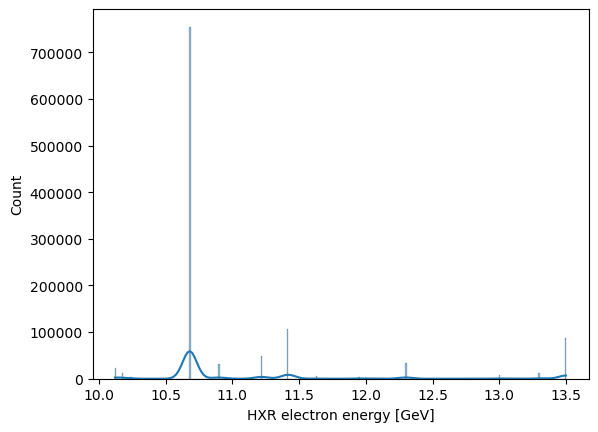

In [21]:
sns.histplot(final_df['HXR electron energy [GeV]'], kde=True)

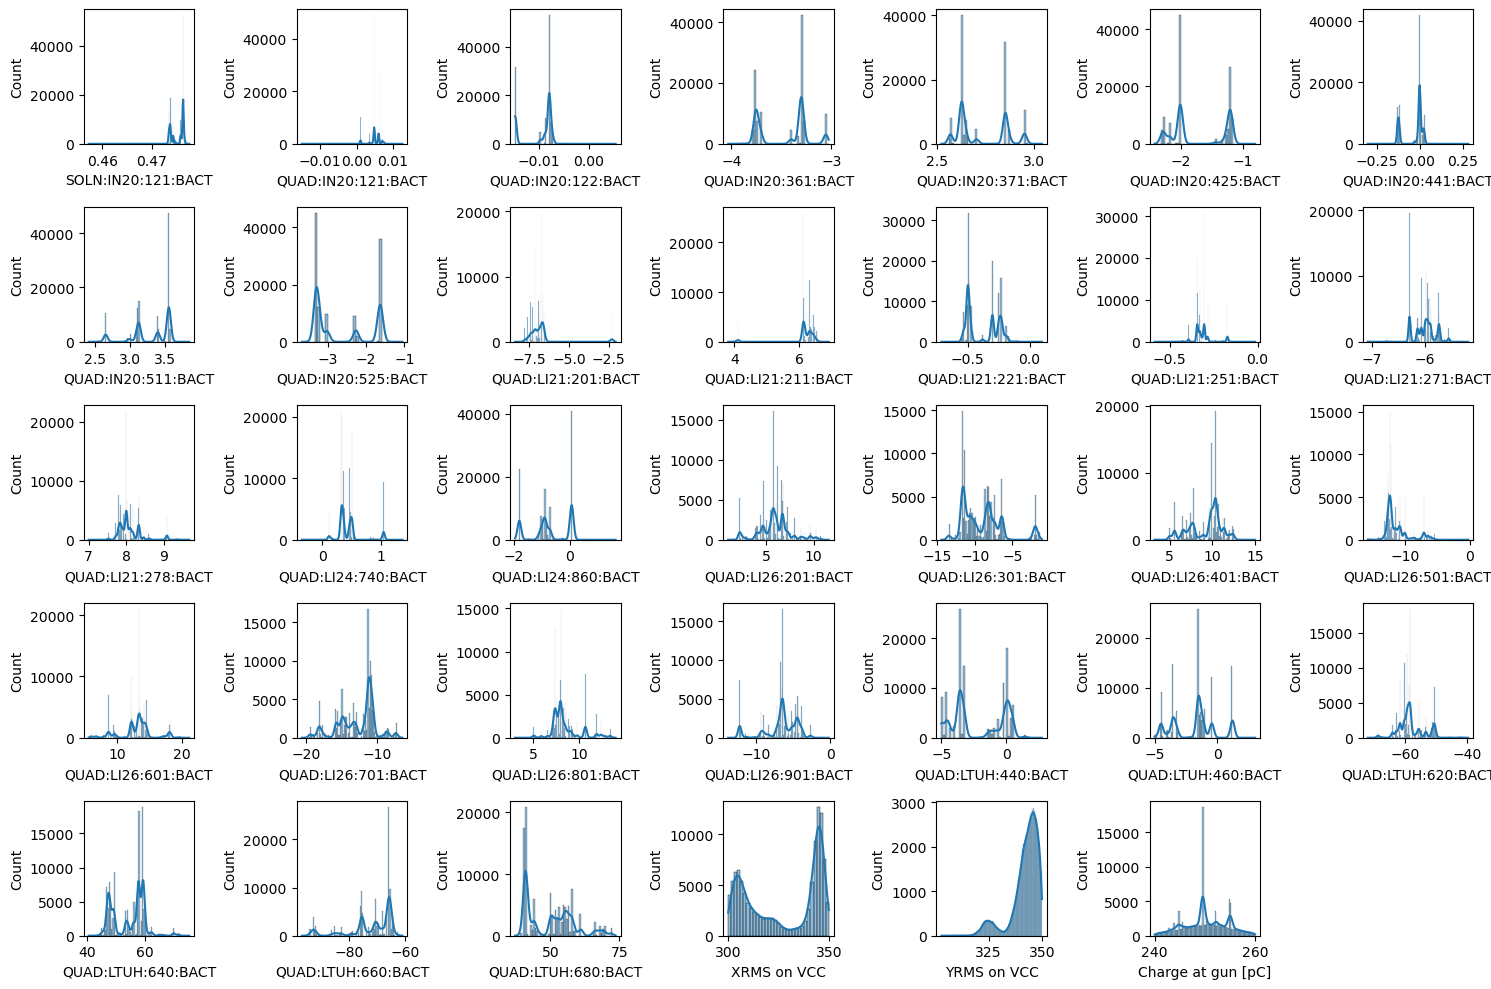

In [34]:
all_cols = input_cols
plt.figure(figsize=(15, 10))
for feature in all_cols:
    plt.subplot(5, 7, all_cols.index(feature) + 1)  # Adjust the subplot layout based on your number of features
    sns.histplot(final_df[feature], kde=True)
    # plt.title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

In [ ]:
# Select a subset of features for diversity analysis
selected_features = input_cols # + output_cols

# Pair plot for selected features
sns.pairplot(final_df[selected_features])
plt.suptitle("Pair Plot of Input Features", y=1.02)
plt.show()

## Build NN model with Pytorch

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from botorch.utils import standardize
from botorch.models.transforms.input import AffineInputTransform, Normalize
import time

In [15]:

# Create a Dataset class for PyTorch
class MyDataset(Dataset):
    def __init__(self, dataframe, input_cols, output_cols):
        self.features = dataframe[input_cols].values
        self.outputs = dataframe[output_cols].values

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = torch.tensor(self.features[idx], dtype=torch.float32)
        y = torch.tensor(self.outputs[idx], dtype=torch.float32)
        return x, y

# Split the dataset into training and testing sets
train_df, test_df = train_test_split(final_df, test_size=0.2, random_state=39)

# Standardization with sklearn
# input_scaler = StandardScaler()
# train_df[input_cols] = input_scaler.fit_transform(train_df[input_cols])
# test_df[input_cols] = input_scaler.transform(test_df[input_cols])
# output_scaler = StandardScaler()
# train_df[output_cols] = output_scaler.fit_transform(train_df[output_cols])
# test_df[output_cols] = output_scaler.transform(test_df[output_cols])

# Standardization with botorch.models.transforms.input.AffineInputTransform
# input_means = final_df[input_cols].mean()
# input_stds = final_df[input_cols].std()
# output_means = final_df[output_cols].mean()
# output_stds = final_df[output_cols].std()
input_mins = final_df[input_cols].min()
input_maxs = final_df[input_cols].max()
output_mins = final_df[output_cols].min()
output_maxs = final_df[output_cols].max()
# Convert means and stds to PyTorch tensors
input_scaler = AffineInputTransform(d=input_size,coefficient=torch.tensor(input_maxs.values-input_mins.values, dtype=torch.float32),
                                                     offset=torch.tensor(input_mins.values, dtype=torch.float32))
output_scaler = AffineInputTransform(d=output_size,coefficient=torch.tensor(output_maxs.values-output_mins.values, dtype=torch.float32),
                                                     offset=torch.tensor(output_mins.values, dtype=torch.float32))

train_df[input_cols] = input_scaler.transform(torch.tensor(train_df[input_cols].values, dtype=torch.float32))
test_df[input_cols] = input_scaler.transform(torch.tensor(test_df[input_cols].values, dtype=torch.float32))
train_df[output_cols] = output_scaler.transform(torch.tensor(train_df[output_cols].values, dtype=torch.float32))
test_df[output_cols] = output_scaler.transform(torch.tensor(test_df[output_cols].values, dtype=torch.float32))

# Create DataLoader instances for training and testing
train_dataset = MyDataset(train_df, input_cols, output_cols)
test_dataset = MyDataset(test_df, input_cols, output_cols)

batch_size = 516

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


### Create model

In [16]:
def create_model(version: int = 0):
    if version == 0:
        model = nn.Sequential(
            nn.Linear(input_size, 100),
            nn.ELU(),
            nn.Linear(100, 200),
            nn.ELU(),
            nn.Dropout(p=0.05),
            nn.Linear(200, 200),
            nn.ELU(),
            nn.Dropout(p=0.05),
            nn.Linear(200, 100),
            nn.ELU(),
            nn.Dropout(p=0.05),
            nn.Linear(100, 32),
            nn.ELU(),
            nn.Linear(32, 1)
        )
    elif version == 1:
        model = nn.Sequential(
                nn.Linear(input_size, 256),
                nn.Sigmoid(),
                nn.Linear(256, 128),
                nn.Sigmoid(),
                nn.Linear(128, 128),
                nn.Sigmoid(),
                nn.Linear(128, 64),
                nn.Sigmoid(),
                nn.Linear(64, 64),
                nn.Sigmoid(),
                nn.Linear(64, 32),
                nn.Sigmoid(),
                nn.Linear(32, 32),
                nn.Sigmoid(),
                nn.Linear(32, 16),
                nn.Sigmoid(),
                nn.Linear(16, output_size)
        )
    elif version == 2:
        model = nn.Sequential(
                nn.Linear(input_size, 32),
                nn.ReLU(),
                nn.Linear(32, 64),
                nn.ReLU(),
                nn.Dropout(p=0.05),
                nn.Linear(64, 64),
                nn.ReLU(),
                nn.Dropout(p=0.05),
                nn.Linear(64, 32),
                nn.ReLU(),
                nn.Dropout(p=0.05),
                nn.Linear(32, 32),
                nn.ReLU(),
                nn.Linear(32, output_size)
            )
    elif version == 3:
        model = nn.Sequential(
                nn.Linear(input_size, 32),
                nn.Sigmoid(),
                nn.Linear(32, 64),
                nn.Sigmoid(),
                nn.Dropout(p=0.05),
                nn.Linear(64, 64),
                nn.Sigmoid(),
                nn.Dropout(p=0.05),
                nn.Linear(64, 32),
                nn.Sigmoid(),
                nn.Dropout(p=0.05),
                nn.Linear(32, 32),
                nn.Sigmoid(),
                nn.Linear(32, output_size)
            )
    elif version == 4:
        model = nn.Sequential(
                nn.Linear(input_size, 512),
                nn.ELU(),
                nn.Linear(512, 256),
                nn.ELU(),
                nn.Linear(256, 128),
                nn.ELU(),
                nn.Linear(128, 64),
                nn.ELU(),
                nn.Linear(64, 64),
                nn.ELU(),
                nn.Linear(64, 32),
                nn.ELU(),
                nn.Linear(32, 32),
                nn.ELU(),
                nn.Linear(32, 16),
                nn.ELU(),
                nn.Linear(16, output_size)
            )
    elif version == 5:
        model = nn.Sequential(
                nn.Linear(input_size, 256),
                nn.ELU(),
                nn.Linear(256, 128),
                nn.ELU(),
                nn.Dropout(p=0.05),
                nn.Linear(128, 64),
                nn.ELU(),
                nn.Dropout(p=0.05),
                nn.Linear(64, 16),
                nn.ELU(),
                nn.Dropout(p=0.05),
                nn.Linear(16, 16),
                nn.ELU(),
                nn.Linear(16, output_size)
            )
    else:
        raise ValueError(f"Unknown model version {version}.")
    return model.float()

In [17]:
model_version = 5
model = create_model(model_version)

In [18]:
lr = 5e-6
weight_decay = 1e-6
n_epochs = 100
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)




EPOCH      TRAIN_LOSS    TEST_LOSS          ETA
0             0.15810      0.14984    13.84 sec
10            0.01217      0.01206    76.41 min
20            0.01220      0.01051    69.52 min
30            0.01138      0.00936    60.76 min
40            0.00962      0.00902    52.72 min
50            0.00860      0.00892    44.20 min
60            0.00875      0.00888    35.26 min
70            0.00847      0.00881    26.37 min
80            0.00774      0.00872    17.28 min
90            0.00832      0.00872     8.19 min


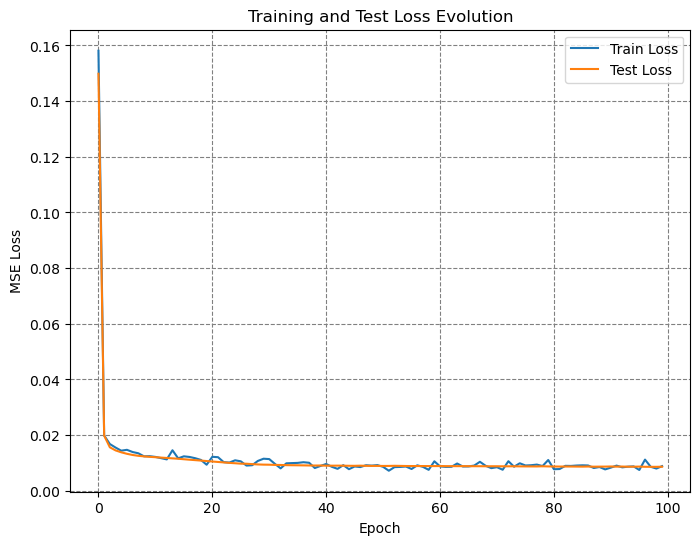

In [19]:
train_losses, test_losses = [], []
print("{:8s} {:>12s} {:>12s} {:>12s}".format("EPOCH", "TRAIN_LOSS", "TEST_LOSS", "ETA"))
t0 = time.time()
best_loss = torch.inf
for epoch in range(n_epochs):
    for i, data in enumerate(train_loader, 0):
        inputs, targets = data

        
        optimizer.zero_grad()
        model.train()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # l1_regularization = sum(torch.norm(param, 1) for param in model.parameters())
        # total_loss = loss + reg * l1_regularization
        # total_loss.backward()
        loss.backward()
        optimizer.step()

        if i == 0:
            model.eval()
            inputs_test, targets_test = next(iter(test_loader))
            outputs_test = model(inputs_test)
            test_loss = criterion(outputs_test, targets_test)

            # store losses
            train_losses.append(loss.item())
            test_losses.append(test_loss.item())

            # print info
            if epoch % (n_epochs // 10) == 0:
                t_avg = (time.time() - t0) / (epoch + 1)
                t_r = (n_epochs - epoch - 1) * t_avg / 60  # in minutes
                if t_r <= 1.0:
                    t_info = "{:.2f} sec".format(60 * t_r)
                else:
                    t_info = "{:.2f} min".format(t_r)
                info = "{:<8d} {:12.5f} {:12.5f} {:>12s}".format(epoch, loss, test_loss, t_info)
                if test_loss < best_loss:
                    info = "\033[0;32m" + info + '\x1b[0m'                
                print(info)
                
# Plot the training and test losses
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(color="gray", linestyle="dashed")
plt.title('Training and Test Loss Evolution')
plt.legend()
plt.show()

Test Loss: 0.0070
 R²:0.63182


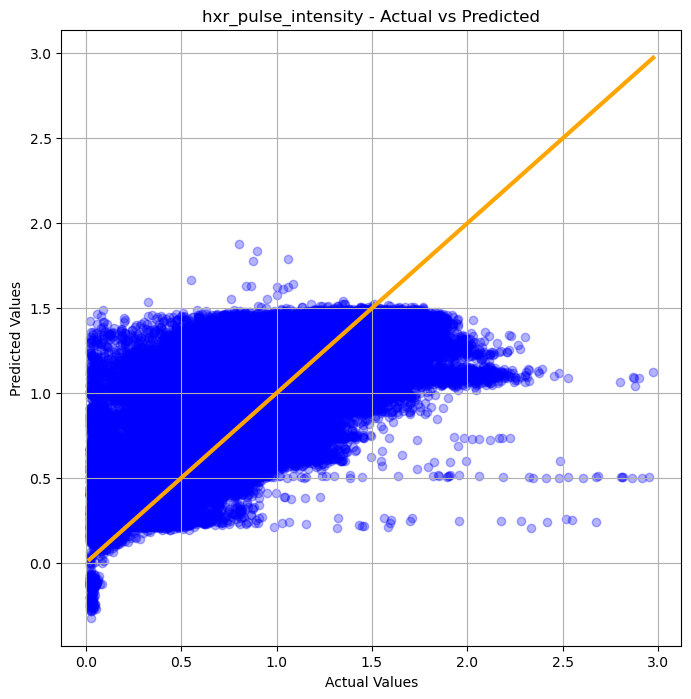

In [17]:
# Function to plot actual vs predicted values
def plot_actual_vs_predicted(actual, predicted, title):
    plt.figure(figsize=(8, 8))
    plt.grid()
    plt.scatter(actual, predicted, color='blue', alpha=0.3)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    r_squared = r2_score(actual, predicted)
    plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], color='orange', linewidth=3)
    plt.title(title)
    print(f' R\u00b2:{r_squared:.5f}')
    plt.show()

# Evaluate the model on the test set
model.eval()
test_loss = 0.0
predictions = []
actual_values = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        test_loss += criterion(outputs, targets).item()

        
        predictions.append(outputs.numpy())
        actual_values.append(targets.numpy())



test_loss /= len(test_loader)

print(f'Test Loss: {test_loss:.4f}')

# Convert lists to NumPy arrays
predictions = np.concatenate(predictions, axis=0)
actual_values = np.concatenate(actual_values, axis=0)

# Calculate R-squared value
# r_squared1 = r2_score(actual_values[:, 0], predictions[:, 0])
# r_squared2 = r2_score(actual_values[:, 1], predictions[:, 1])

# transform the scaled outputs into original ones with sklearn
# predictions = output_scaler.inverse_transform(predictions)
# actual_values = output_scaler.inverse_transform(actual_values)

# transform the scaled outputs into original ones with botorch
predictions = output_scaler._untransform(torch.tensor(predictions))
actual_values = output_scaler._untransform(torch.tensor(actual_values))

# Plot actual vs predicted values for each output
for i, output_col in enumerate(output_cols):
    plot_actual_vs_predicted(actual_values[:, i], predictions[:, i], f'{output_col} - Actual vs Predicted')



In [21]:
file_dir = '/sdf/data/ad/ard/u/zihanzhu/ml/lcls_fel_tuning/dataset/'  
pickle_files = 'hxr_archiver_Jan_latest.pkl'
new_test_df = pd.read_pickle(file_dir+pickle_files).reset_index(drop=True)
new_test_df = dataset_filter(new_test_df)[:]
# new_test_df = valid_df
print('Number of effective samples in test set:', new_test_df.shape[0])

# input_cols_bctrl = quads_inj_bctrl + quads_linac_bctrl + quads_ltuh_bctrl + beam_status
output_cols = ['hxr_pulse_intensity']
# Calculate moving average with a window
window_size = 100
moving_avg = new_test_df[output_cols].rolling(window=window_size).mean()

# Display the original data and the moving average
# new_test_df_updated = new_test_df.copy()
new_test_df['moving_avg'] = moving_avg

sample_interval = 10
indices = np.round(np.arange(0,new_test_df.shape[0] - 1,sample_interval))[:]
# ----------------------
# num_samples_to_plot = 100
# indices = np.random.randint(0, new_test_df.shape[0] - 1, num_samples_to_plot)
# --------------------------
print('Number of samples for model validation:', indices.shape[0])
num_samples_to_plot = indices.shape[0]
ground_truth = new_test_df[output_cols].iloc[indices].values
ground_truth_moving_avg = new_test_df['moving_avg'].iloc[indices].values




Number of effective samples in test set: 359060
Number of samples for model validation: 35906


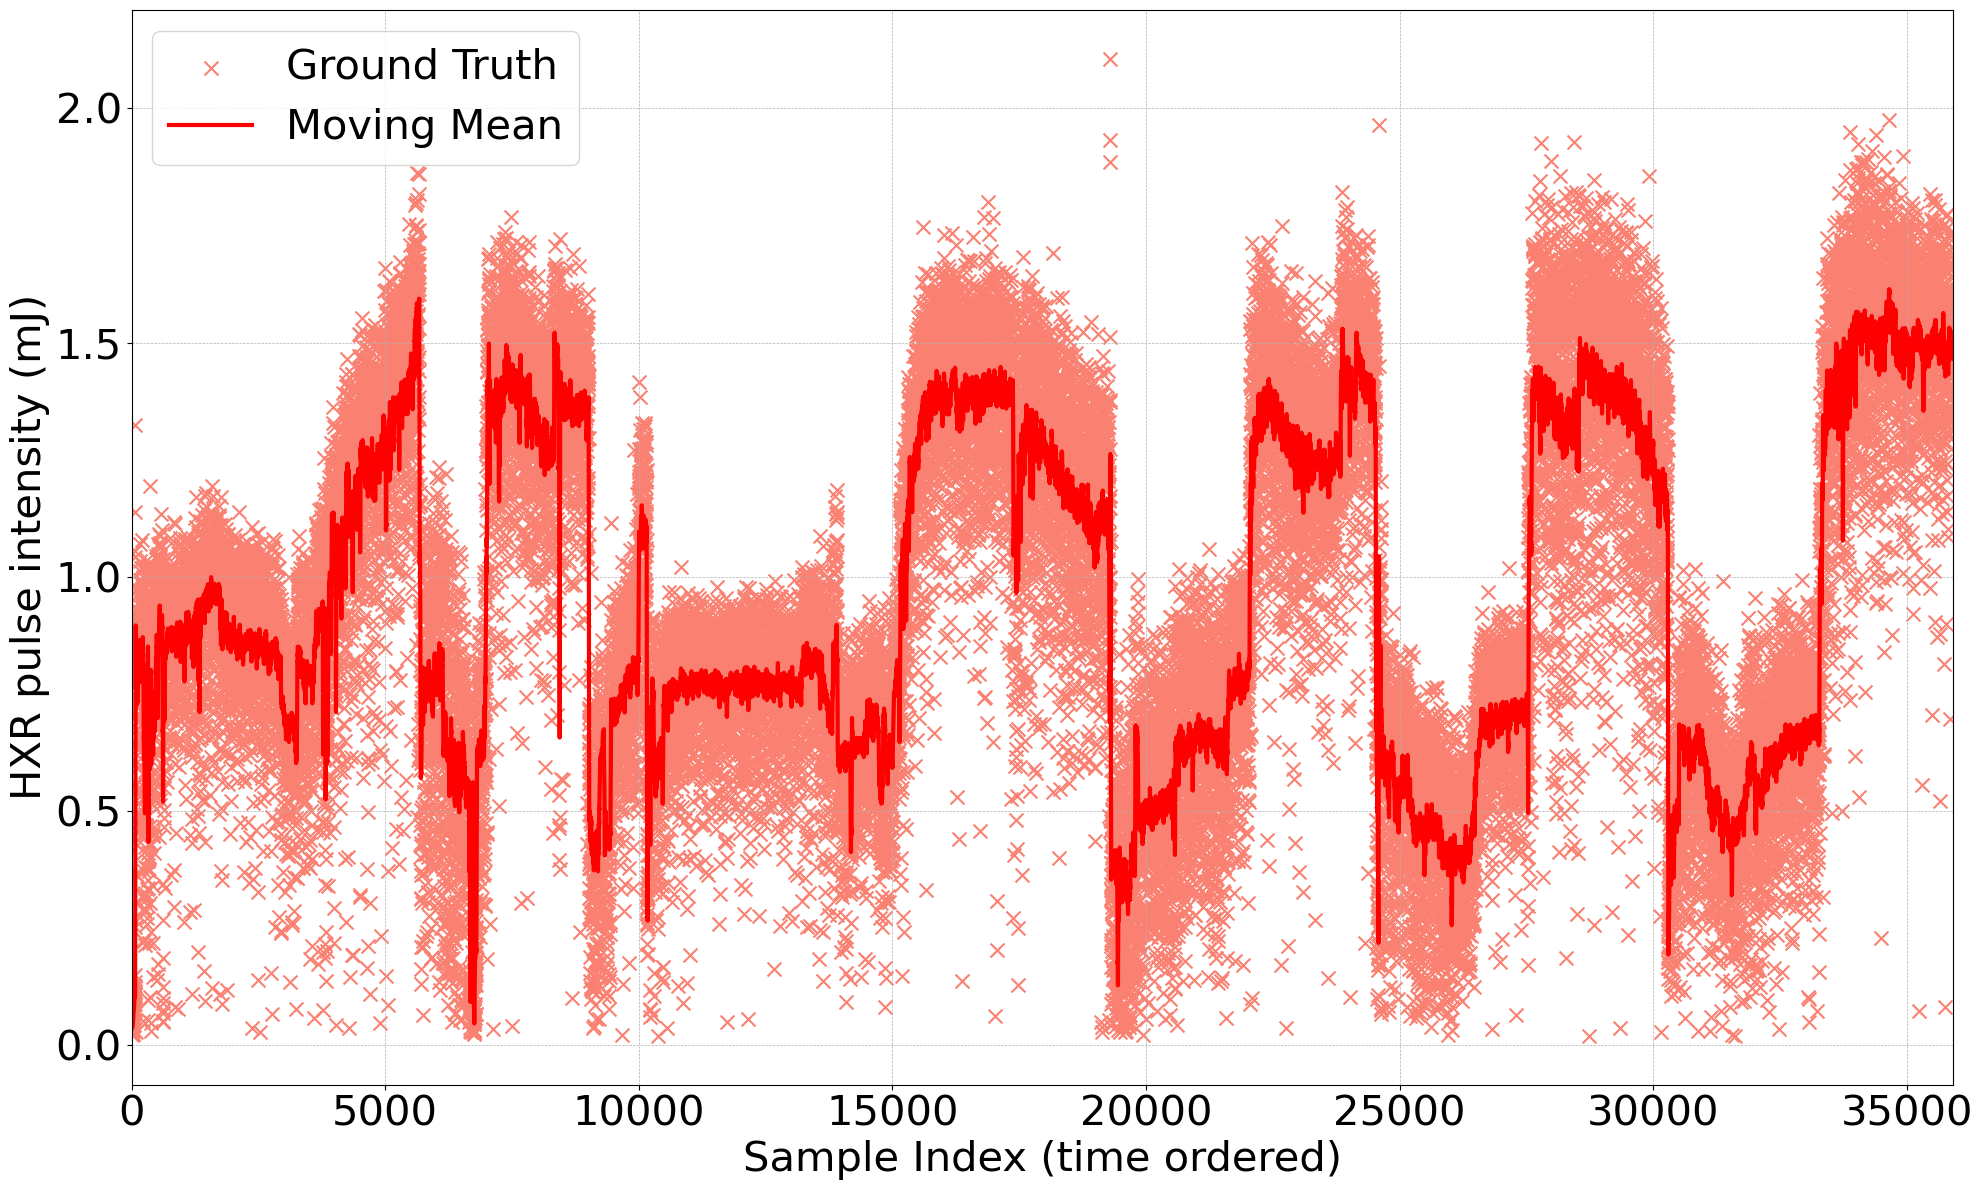

In [22]:
shot_axis = np.arange(len(ground_truth))
plt.figure(figsize=(20,12))
plt.scatter(shot_axis, ground_truth, label='Ground Truth', color='salmon', marker='x',s=100)
plt.plot(ground_truth_moving_avg, label='Moving Mean', color='red', linewidth=3)
fontsize = 30
plt.xlabel('Sample Index (time ordered)', fontsize=fontsize)
plt.ylabel('HXR pulse intensity (mJ)',fontsize=fontsize)
plt.xlim([0, num_samples_to_plot])
# plt.ylim([-0, 3])
plt.legend(fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

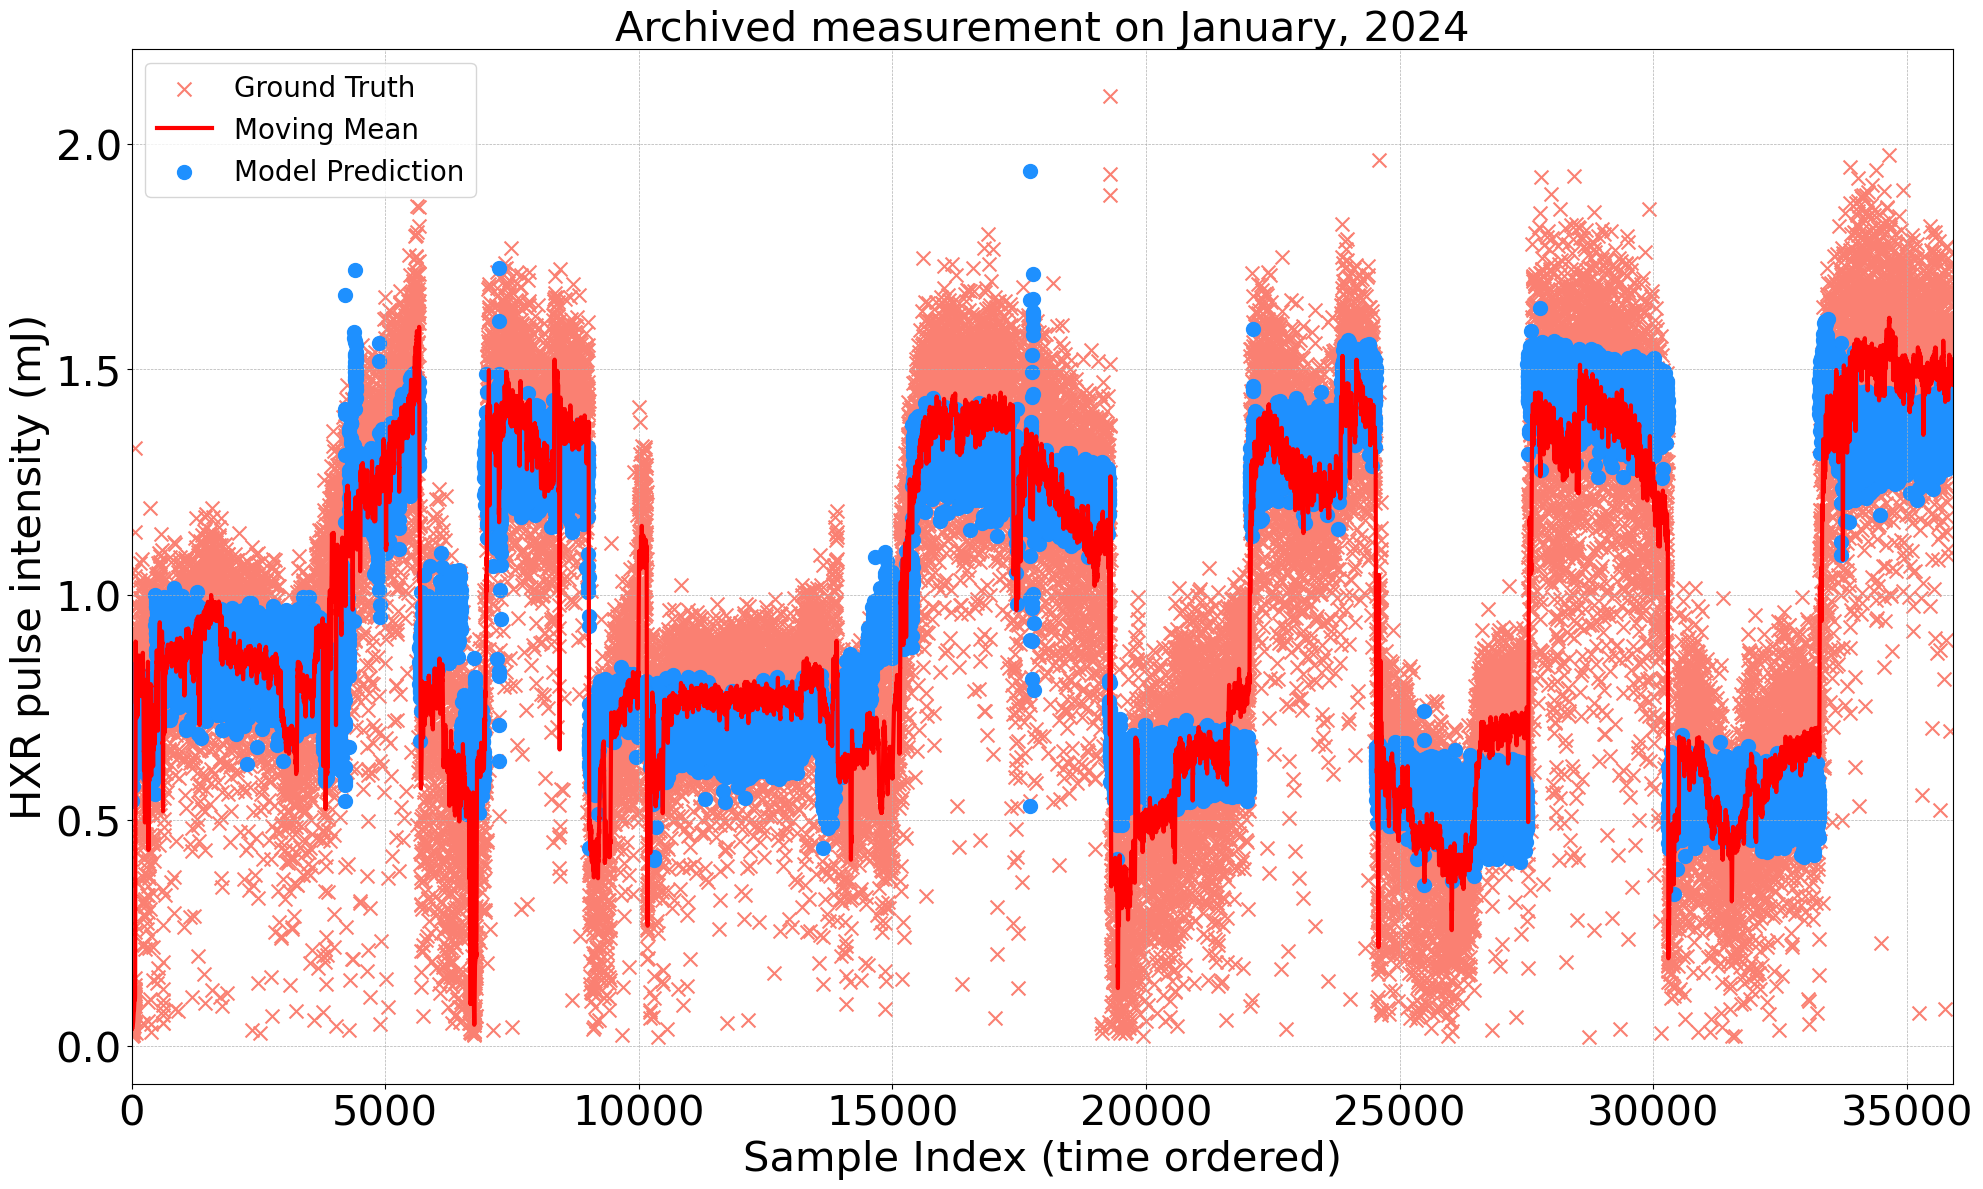

In [23]:
fontsize = 30
plt.figure(figsize=(20,12))
shot_axis = np.arange(len(ground_truth))
# Ground truth and predictions for the selected a subset
scaled_inputs = input_scaler.transform(torch.tensor(new_test_df[input_cols].iloc[indices].values.astype('float32'), dtype=torch.float32)) # for botorch
# Pass the scaled inputs through your model
model_outputs = model(scaled_inputs)

# Inverse transform the model outputs using the output_scaler
# final_output = output_scaler.inverse_transform(model_outputs.detach().numpy()) # for sklearn
final_prediction = output_scaler._untransform(model_outputs).detach().numpy() # for botorch 

plt.scatter(shot_axis, ground_truth, label='Ground Truth', color='salmon', marker='x',s=100)
# plt.scatter(shot_axis, new_mean_predictions_loaded2, label='Model2 prediction', color='yellowgreen', marker='o', s=100)

plt.plot(ground_truth_moving_avg, label='Moving Mean', color='red', linewidth=3)
plt.scatter(shot_axis, final_prediction[:,0], label='Model Prediction', color='dodgerblue', marker='o', s=100)
    
# lower_bound2 = (new_mean_predictions_loaded2 - 2 * new_std_predictions_loaded2).numpy().flatten()
# upper_bound2 = (new_mean_predictions_loaded2 + 2 * new_std_predictions_loaded2).numpy().flatten()
# plt.fill_between(range(num_samples_to_plot), lower_bound2, upper_bound2, color='yellowgreen', alpha=0.3)

plt.xlabel('Sample Index (time ordered)', fontsize=fontsize)
plt.ylabel('HXR pulse intensity (mJ)',fontsize=fontsize)
plt.title('Archived measurement on January, 2024',fontsize=fontsize)
plt.xlim([0, num_samples_to_plot])
# plt.ylim([-2.2, 2.2])
plt.legend(fontsize=20, loc='upper left')
plt.tick_params(labelsize=fontsize)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.show()

In [20]:
# Save the model
model_path = '/sdf/data/ad/ard/u/zihanzhu/ml/lcls_fel_tuning/model/'
nn_folder_name = datetime.now().strftime("%Y-%m-%d_%H-%M-%S") + '_nn/'
nn_path = os.path.join(model_path, nn_folder_name)

# Create directory if it does not exist
if not os.path.exists(nn_path):
    os.makedirs(nn_path)

torch.save(input_scaler, nn_path + 'lcls_fel_input_scaler.pt')
torch.save(output_scaler, nn_path + 'lcls_fel_output_scaler.pt')
torch.save(model, nn_path + 'lcls_fel_model.pt')

file_name = 'feature_config.yml'
yaml_dump = variables_as_yaml(input_variables, output_variables, nn_path+file_name)

print(f"Model and scalers saved in: {nn_folder_name}")

Model and scalers saved in: 2024-04-08_09-28-48_nn/


# Model response to 1D variable scan 

### Load model

In [24]:
# Specify the path to the saved files
model_path = '/sdf/data/ad/ard/u/zihanzhu/ml/lcls_fel_tuning/model/'
model_version = '2024-04-08_06-02-49_nn/'
loaded_model_path = model_path + model_version + 'lcls_fel_model.pt'
loaded_input_scaler_path = model_path + model_version + 'lcls_fel_input_scaler.pt'
loaded_output_scaler_path = model_path + model_version + 'lcls_fel_output_scaler.pt'

# Load the model state dictionary
model = torch.load(loaded_model_path)

# Load the model state dictionary
input_scaler = torch.load(loaded_input_scaler_path)
output_scaler = torch.load(loaded_output_scaler_path)



# Extract input and output columns
input_cols, output_cols = variables_from_yaml(model_path + model_version + 'feature_config.yml')

### Create a LUME model to wrap input, output transformers and neural network intor TorchModule

In [25]:
# create TorchModel
lume_model = TorchModel(
    model=loaded_model_path,
    input_variables=input_cols,
    output_variables=output_cols,
    input_transformers=[input_scaler],
    output_transformers=[output_scaler],
)



In [26]:
# wrap in TorchModule
lume_module = TorchModule(
    model=lume_model,
    input_order=lume_model.input_names,
    output_order=lume_model.output_names,
)

lume_module

TorchModule(
  (base_model): Sequential(
    (0): Linear(in_features=42, out_features=256, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ELU(alpha=1.0)
    (4): Dropout(p=0.05, inplace=False)
    (5): Linear(in_features=128, out_features=64, bias=True)
    (6): ELU(alpha=1.0)
    (7): Dropout(p=0.05, inplace=False)
    (8): Linear(in_features=64, out_features=16, bias=True)
    (9): ELU(alpha=1.0)
    (10): Dropout(p=0.05, inplace=False)
    (11): Linear(in_features=16, out_features=16, bias=True)
    (12): ELU(alpha=1.0)
    (13): Linear(in_features=16, out_features=1, bias=True)
  )
  (input_transformers_0): AffineInputTransform()
  (output_transformers_0): AffineInputTransform()
)

IndexError: list index out of range

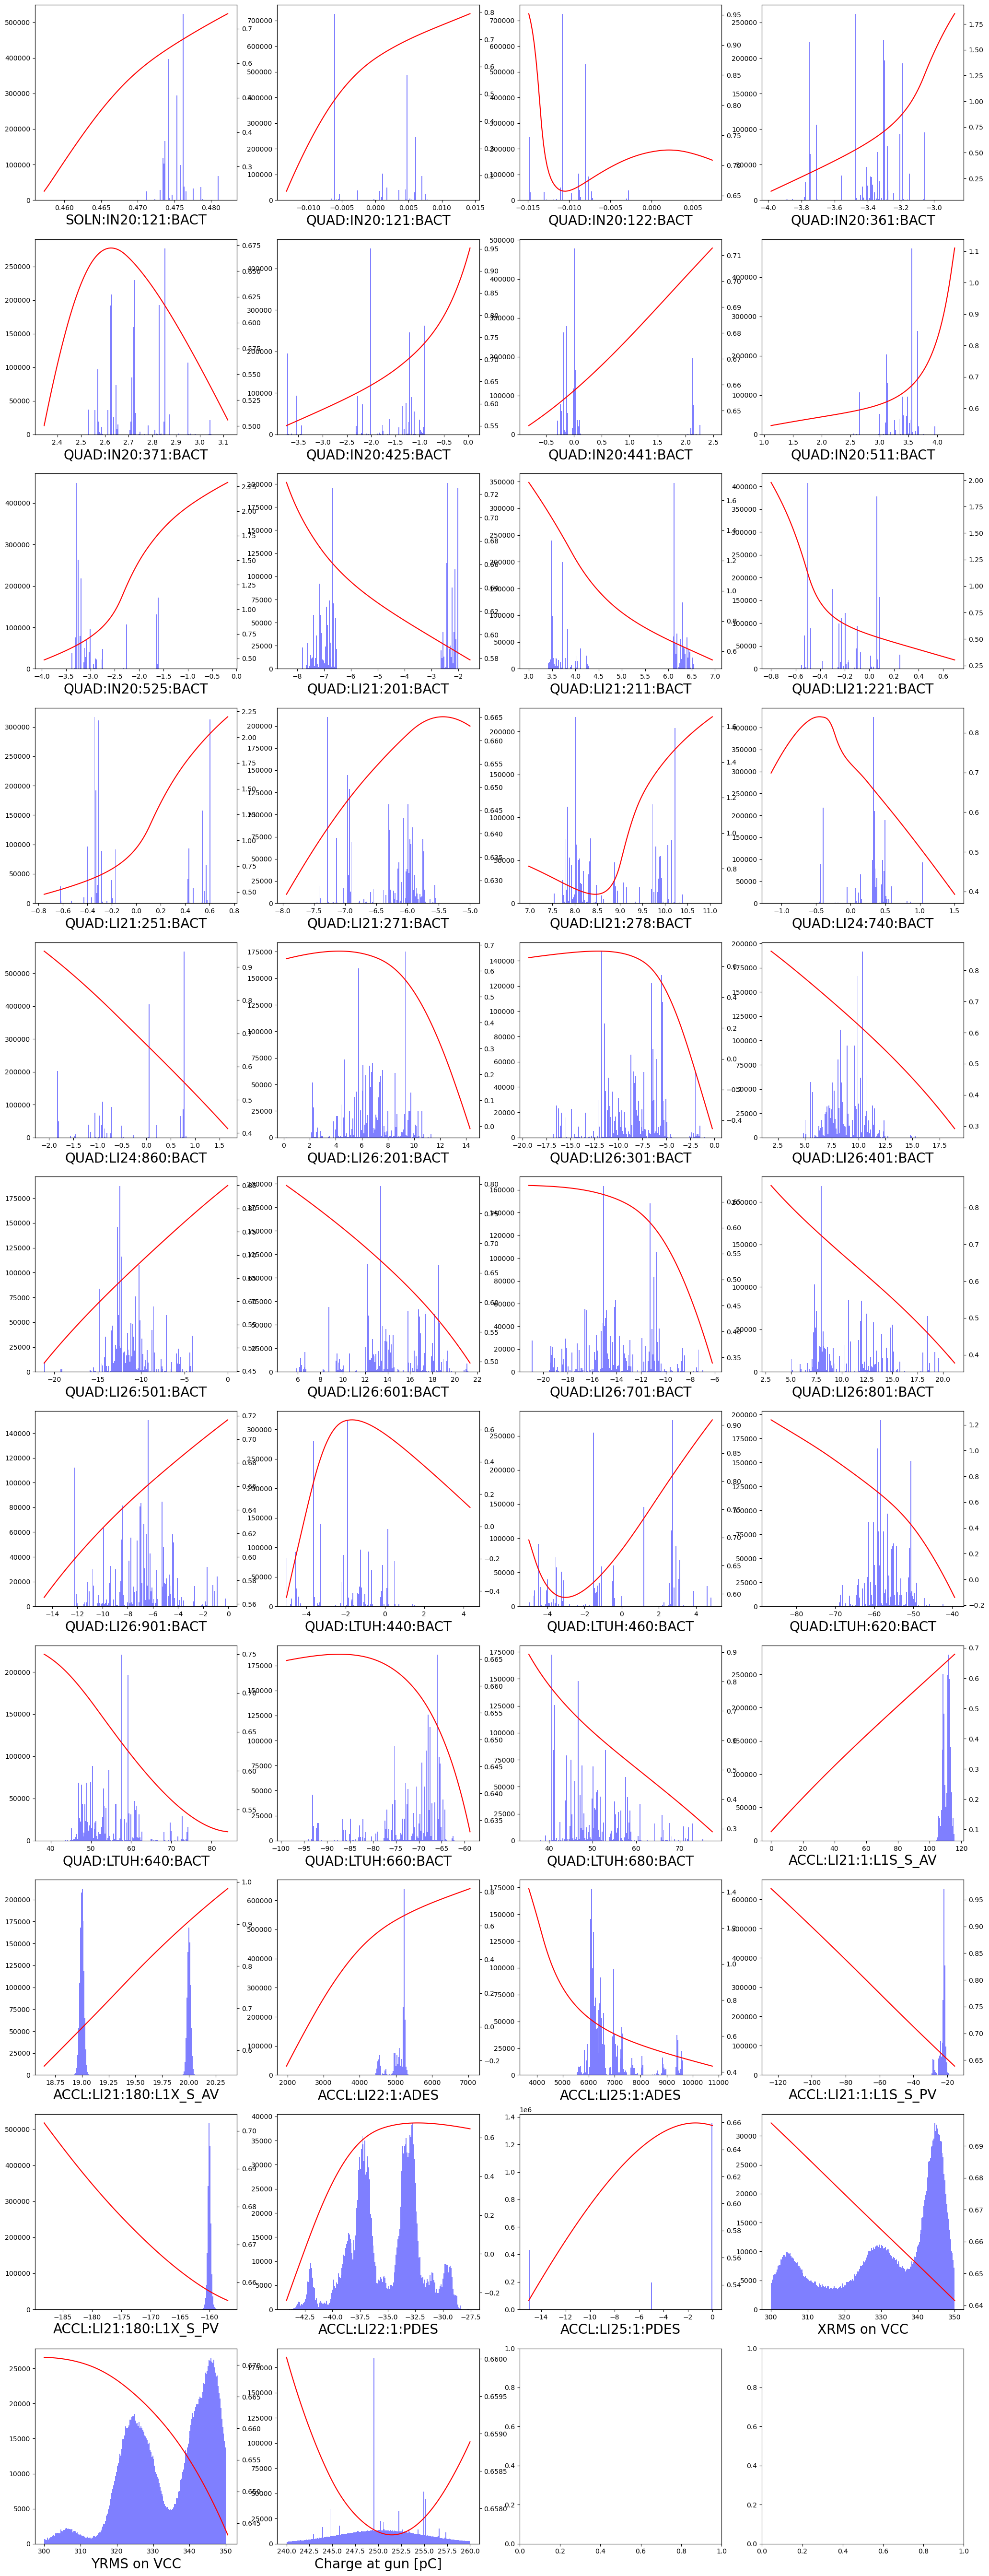

In [27]:
nrows, ncols = 11, 4
figsize = (25, 25 * nrows / ncols)

fig, ax1 = plt.subplots(nrows=nrows, ncols=ncols, sharey=False, figsize=figsize)


for i in range(nrows * ncols):
    ax_i = ax1[i // ncols, i % ncols]
    column_name = input_cols[i].name
    lower_limit = np.percentile(final_df[column_name], 0)
    upper_limit = np.percentile(final_df[column_name], 100)
    step = (upper_limit - lower_limit) / 100  # define your step size
    
    median_row = pd.DataFrame(final_df.median()).transpose()
    # Create an empty DataFrame to store the results
    scanned_df = pd.DataFrame(columns=final_df.columns)
    
    # Iterate over the range of values you want for the specific column
    for i, value in enumerate(np.arange(lower_limit, upper_limit + step, step)):
        # Create a copy of the original DataFrame
        new_row = median_row.copy()
        
        # Modify the specific column with the current value
        new_row.at[0, column_name] = value  

        scanned_df = pd.concat([scanned_df, new_row], ignore_index=True)
    
        # # Transform the input data using the input_scaler
        # # scaled_inputs = torch.from_numpy(input_scaler.transform(scanned_df[input_cols].values)).float() # for sklearn
        # scaled_inputs = input_scaler.transform(torch.tensor(scanned_df[input_cols].values.astype('float32'), dtype=torch.float32)) # for botorch
        # # Pass the scaled inputs through your model
        # model_outputs = model(scaled_inputs)
        # # Inverse transform the model outputs using the output_scaler
        # # final_output = output_scaler.inverse_transform(model_outputs.detach().numpy()) # for sklearn
        # final_output = output_scaler._untransform(model_outputs).detach().numpy() # for botorch  

        final_output = lume_module(torch.tensor(scanned_df[lume_model.input_names].values))
    ax_i.hist(final_df[column_name], bins=200, color="blue", alpha=0.5)
    ax2 = ax_i.twinx()
    ax2.plot(scanned_df[column_name], final_output, color="red")
    ax_i.set_xlabel(column_name, fontsize=20)
    ax_i.tick_params(axis='x', labelsize=10)
    # if i % ncols == 0:
        # ax_i.set_ylabel("HXR pulse intensity")
    
fig.tight_layout()
